# Đánh giá hiệu suất của các mô hình kết hợp

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

### Bước 1: Đọc và Chuẩn bị Dữ liệu
Mô tả: Đọc dữ liệu từ các file CSV và chuẩn bị tập huấn luyện (X_train_smote, y_train_smote) và tập kiểm tra (X_test, y_test). Chuyển nhãn (y) thành dạng Series để phù hợp với các mô hình.

In [60]:
# Đọc dữ liệu từ file CSV
X_train_smote = pd.read_csv('Dataset/dataset_combined/UNSW_NB15_X_train_smote.csv')
y_train_smote = pd.read_csv('Dataset/dataset_combined/UNSW_NB15_y_train_smote.csv')
X_test = pd.read_csv('Dataset/dataset_combined/UNSW_NB15_X_test.csv')
y_test = pd.read_csv('Dataset/dataset_combined/UNSW_NB15y_test.csv')

# Chuyển y_train_smote và y_test thành Series
y_train_smote = y_train_smote.iloc[:, 0]
y_test = y_test.iloc[:, 0]

# Kiểm tra dữ liệu (tùy chọn)
print("Kích thước X_train_smote:", X_train_smote.shape)
print("Kích thước y_train_smote:", y_train_smote.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train_smote: (263476, 42)
Kích thước y_train_smote: (263476,)
Kích thước X_test: (51535, 42)
Kích thước y_test: (51535,)


### Bước 2: Định nghĩa và Huấn luyện Các Mô hình Random Forest
Mô tả: Định nghĩa 6 mô hình Random Forest với các biến thể khác nhau (Basic, Optimized, Weighted, Feature Selection, Reduced Data, Extra Trees). Huấn luyện từng mô hình và dự đoán trên tập kiểm tra.

In [63]:
# --- Định nghĩa 6 mô hình Random Forest kết hợp ---

# 1. Random Forest cơ bản (Basic)
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_basic.fit(X_train_smote, y_train_smote)
y_pred_basic = rf_basic.predict(X_test)

# 2. Random Forest với tham số tối ưu (GridSearchCV) - giảm số tham số
param_grid = {
    'n_estimators': [100, 150],  # Giảm số lựa chọn
    'max_depth': [10, None]      # Giảm số lựa chọn
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train_smote, y_train_smote)
rf_optimized = grid_search.best_estimator_
y_pred_optimized = rf_optimized.predict(X_test)
print("Tham số tối ưu:", grid_search.best_params_)

# 3. Random Forest với Class Weight
rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_weighted.fit(X_train_smote, y_train_smote)
y_pred_weighted = rf_weighted.predict(X_test)

# 4. Random Forest với Feature Selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_smote, y_train_smote)
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_train_selected, y_train_smote)
y_pred_feature_selection = rf_feature_selection.predict(X_test_selected)

# 5. Random Forest với Reduced Data (Lấy mẫu ngẫu nhiên 50% dữ liệu huấn luyện)
train_data = pd.concat([X_train_smote, y_train_smote.rename('label')], axis=1)
train_reduced = train_data.sample(frac=0.5, random_state=42)  # Lấy 50% dữ liệu
X_train_reduced = train_reduced.drop(columns=['label'])
y_train_reduced = train_reduced['label']
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_reduced = rf_reduced.predict(X_test)

# 6. Random Forest với Extra Trees
rf_extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)
rf_extra_trees.fit(X_train_smote, y_train_smote)
y_pred_extra_trees = rf_extra_trees.predict(X_test)

# Danh sách mô hình và dự đoán
rf_models = {
    'RandomForest Basic': y_pred_basic,
    'RandomForest Optimized': y_pred_optimized,
    'RandomForest Weighted': y_pred_weighted,
    'RandomForest Feature Selection': y_pred_feature_selection,
    'RandomForest Reduced Data': y_pred_reduced,
    'RandomForest Extra Trees': y_pred_extra_trees
}

Tham số tối ưu: {'max_depth': None, 'n_estimators': 150}


### Bước 3: Đánh giá Hiệu suất của Các Mô hình

Mô tả: Đánh giá từng mô hình bằng các chỉ số hiệu suất (Accuracy, Precision, Recall, F1-Score) và lưu ma trận nhầm lẫn để sử dụng sau này.

In [78]:
# Lưu ma trận nhầm lẫn và chỉ số hiệu suất
confusion_matrices_rf = {}
performance_metrics_rf = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Đánh giá từng mô hình
for model_name, y_pred in rf_models.items():
    print(f"\n=== Đánh giá mô hình: {model_name} ===")
    
    # Báo cáo phân loại
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Báo cáo phân loại:")
    print(classification_report(y_test, y_pred))
    
    # Lưu chỉ số hiệu suất
    performance_metrics_rf['Model'].append(model_name)
    performance_metrics_rf['Accuracy'].append(report['accuracy'])
    performance_metrics_rf['Precision'].append(report['weighted avg']['precision'])
    performance_metrics_rf['Recall'].append(report['weighted avg']['recall'])
    performance_metrics_rf['F1-Score'].append(report['weighted avg']['f1-score'])
    
    # Tính và lưu ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_rf[model_name] = cm

# Hiển thị bảng tổng hợp hiệu suất
performance_df = pd.DataFrame(performance_metrics_rf)
print("\nBảng tổng hợp hiệu suất:")
print(performance_df)


=== Đánh giá mô hình: RandomForest Basic ===
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18600
           1       0.97      0.96      0.96     32935

    accuracy                           0.95     51535
   macro avg       0.95      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535


=== Đánh giá mô hình: RandomForest Optimized ===
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18600
           1       0.97      0.96      0.96     32935

    accuracy                           0.95     51535
   macro avg       0.95      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535


=== Đánh giá mô hình: RandomForest Weighted ===
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18600
           1       0.97      0.96  

### Bước 4: Vẽ Ma trận Nhầm lẫn
Mô tả: Sử dụng Seaborn để vẽ ma trận nhầm lẫn của từng mô hình dưới dạng lưới 2x3 (6 ô, không có ô trắng).

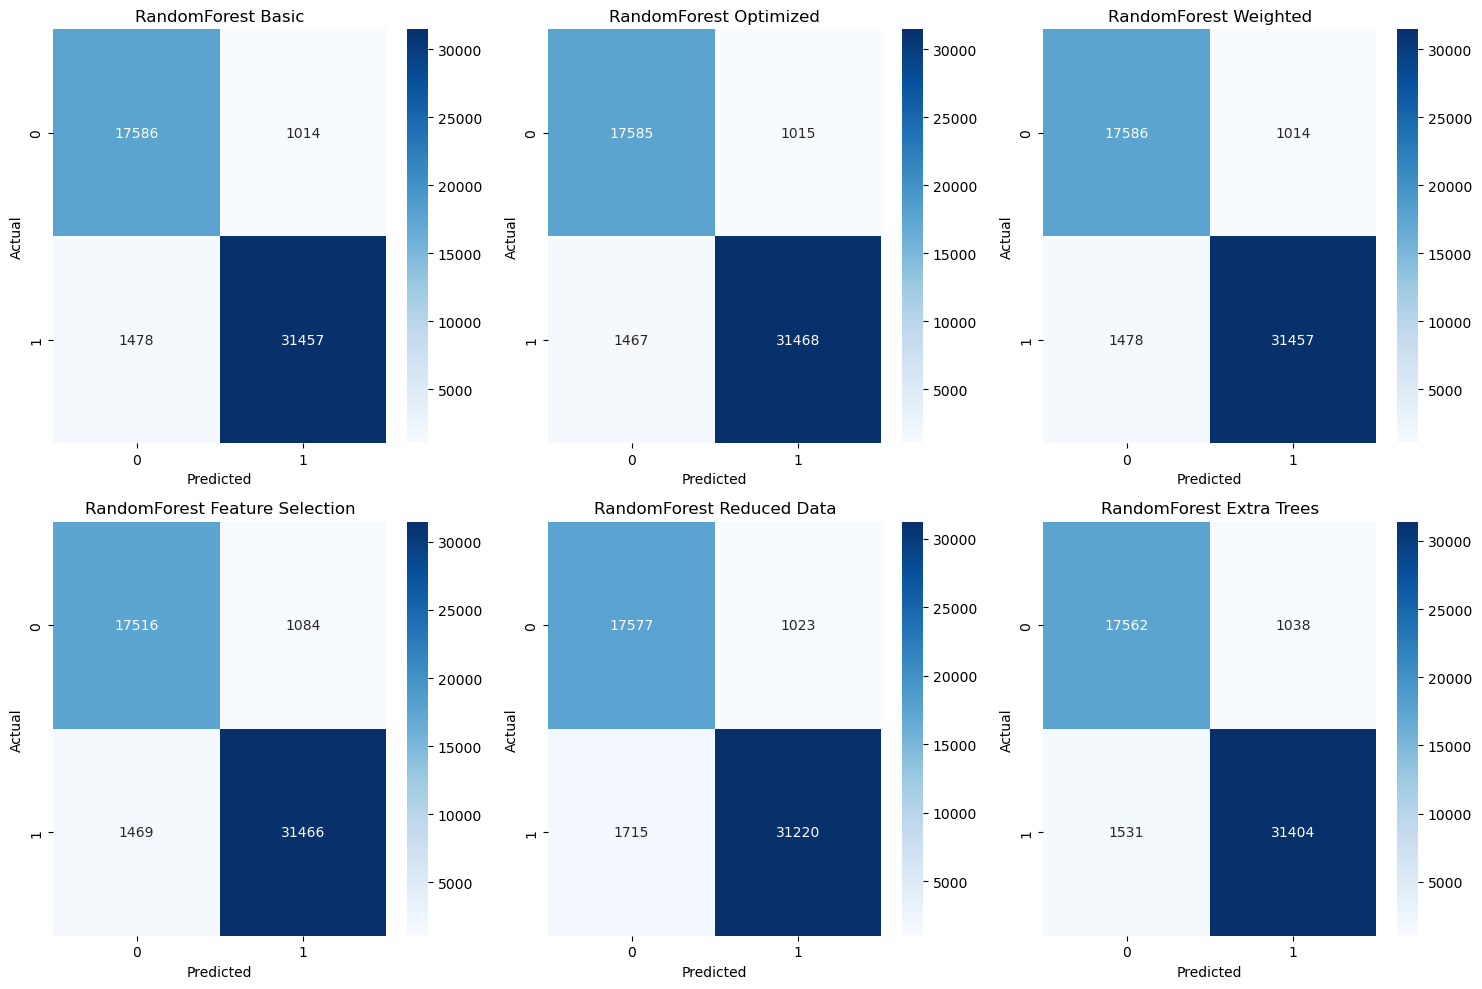

In [81]:
# Vẽ ma trận nhầm lẫn dạng lưới 2x3
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, cm) in enumerate(confusion_matrices_rf.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(model_name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Bước 5: Vẽ biểu đồ so sánh hiệu suất

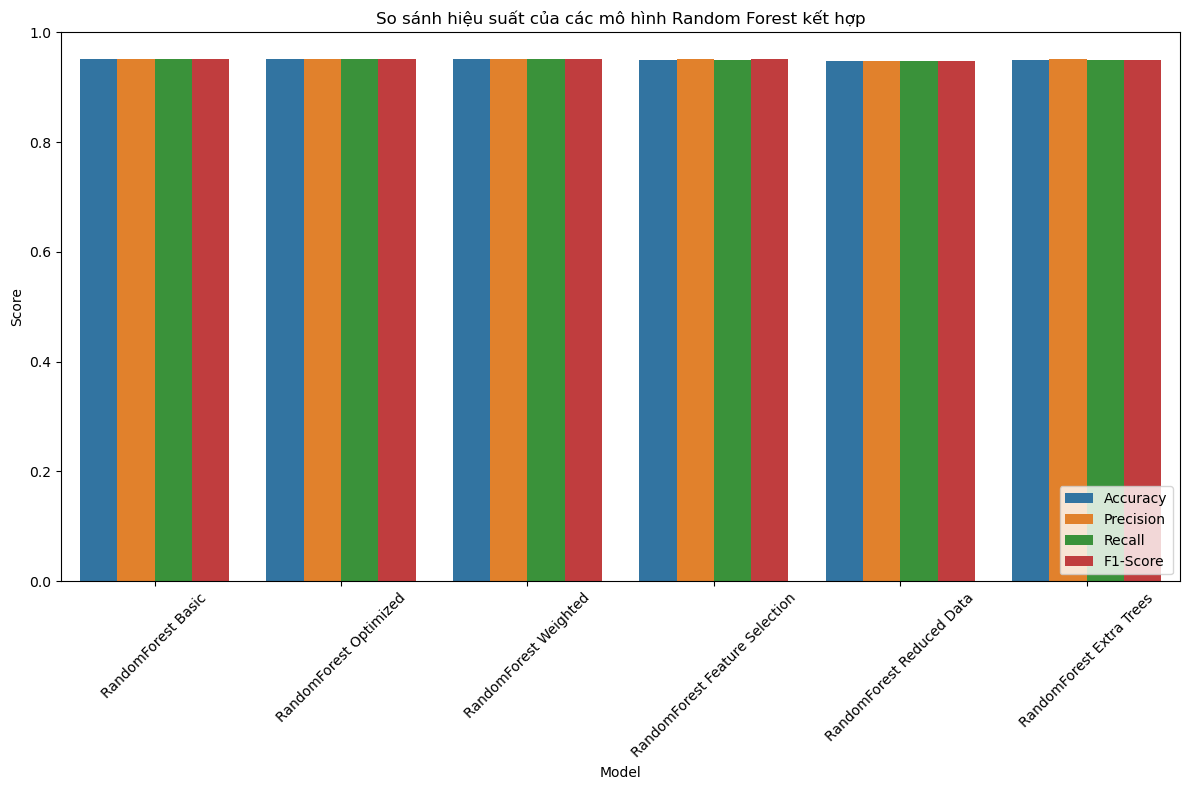

In [40]:
# Vẽ biểu đồ so sánh hiệu suất
performance_df_rf = pd.DataFrame(performance_metrics_rf)
performance_df_melted_rf = performance_df_rf.melt(id_vars='Model', 
                                                  value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                                                  var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=performance_df_melted_rf)
plt.title('So sánh hiệu suất của các mô hình Random Forest kết hợp')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()